In [4]:
import numpy as np
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.optimize import curve_fit
import ipywidgets as widgets
from matplotlib.ticker import FormatStrFormatter
import pytraj as pt
import nglview as nv

# read in the data

df_GDP = pd.read_csv('./summary_GDP.csv', header=0) #change csv name
df_GTP = pd.read_csv('./summary_GTP.csv', header=0)

timepoints = df_GDP['Deut Time (sec)'].unique()
peptides_GDP = df_GDP['Sequence'].unique()
peptides_GTP = df_GTP['Sequence'].unique()

df_peptides_resnum = df_GDP[["Start","End","Sequence"]]
df_peptides_resnum = df_peptides_resnum.drop_duplicates()
peptide_resnums = {}
for index, row in df_peptides_resnum.iterrows():
    peptide_resnums[ row['Sequence'] ] = row['Start'], row['End']

peptides_both = set(peptides_GDP).intersection(peptides_GTP)
peptides_one = set(peptides_GDP).difference(peptides_GTP)

In [30]:
dropdown_peptides = []
for peptide in peptides_both:
    peptide_start = str(peptide_resnums.get(peptide)[0])
    peptide_end = str(peptide_resnums.get(peptide)[1])
    dropdown_peptides.append(peptide_start + '- ' + peptide)
dropdown_peptides = sorted(dropdown_peptides)

DDwidget = widgets.Dropdown(
    options = dropdown_peptides,
    value = '48- VEVHPLSF',
    description = 'Peptide 1:',
    disabled = False,
)

DDwidget2 = widgets.Dropdown(
    options = dropdown_peptides,
    value = '150- YDISAKSNYNFEKPFL',
    description = 'Peptide 2:',
    disabled = False,
)

display(DDwidget)
display(DDwidget2)

Dropdown(description='Peptide 1:', index=88, options=('1- GSSAPAANGEVPTF', '1- GSSAPAANGEVPTFKL', '1- GSSAPAAN…

Dropdown(description='Peptide 2:', index=22, options=('1- GSSAPAANGEVPTF', '1- GSSAPAANGEVPTFKL', '1- GSSAPAAN…

/Users/anumglasgow/miniconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/anumglasgow/miniconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',



PDB ID: 3M1I (Gsp1-GTP). 
Oriented with the C-terminal subdomain at the top.

Use the mouse to move the structure. 
Double-click for full-screen. Type "R" to zoom out, "I" to rotate, and "K" to rock.
NGLViewer, an amazing tool: H Nguyen, DA Case and AS Rose, Bioinformatics, 2017. doi:10.1093/bioinformatics/btx789

Peptide VASPALAPPEVQVD, residues 58-56, shown as orange surface and sticks.
Peptide YTNFGEIKF, residues 58-56, shown as blue surface and sticks.


NGLWidget()

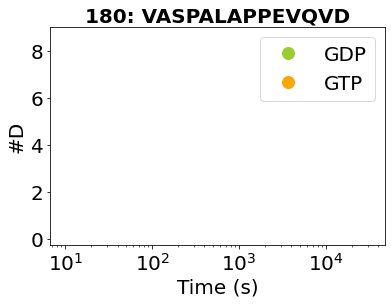

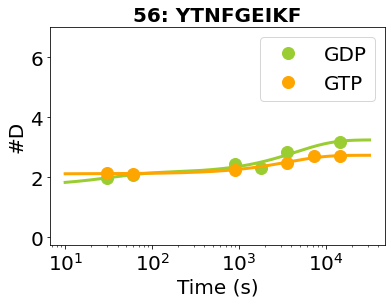

In [37]:
peptide_input1 = str(DDwidget.value)
peptide_input1 = peptide_input1.split()[-1]

peptide_input2 = str(DDwidget2.value)
peptide_input2 = peptide_input2.split()[-1]

selected_peptides = [peptide_input1, peptide_input2]

for peptide in selected_peptides:
    GDP_exchanged = []
    GTP_exchanged = []
    num_prolines = peptide[2:].count('P')
    max_protons = len(peptide) - 2 - num_prolines

    df_GDP_subset = df_GDP[["Sequence","Deut Time (sec)","#D"]]
    df_GTP_subset = df_GTP[["Sequence","Deut Time (sec)","#D"]]
    df_GDP_peptide = df_GDP_subset[df_GDP_subset["Sequence"] == peptide]
    df_GTP_peptide = df_GTP_subset[df_GTP_subset["Sequence"] == peptide]
        
    for timepoint in timepoints:
        df_GDP_tp = df_GDP_peptide[df_GDP_peptide["Deut Time (sec)"] == timepoint]
        GDP_exchanged.append(df_GDP_tp['#D'])
        df_GTP_tp = df_GTP_peptide[df_GTP_peptide["Deut Time (sec)"] == timepoint]
        GTP_exchanged.append(df_GTP_tp['#D'])
        
    GDP_timepoints = []
    GDP_index = 0
    GDP_exchanged_ = []
    for x in GDP_exchanged:
        if not math.isnan(float(x)):
            GDP_timepoints.append(timepoints[GDP_index])
            GDP_exchanged_.append(float(x))
        GDP_index = GDP_index + 1
        
    GTP_timepoints = []
    GTP_index = 0
    GTP_exchanged_ = []
    for x in GTP_exchanged:
        if not math.isnan(float(x)):
            GTP_timepoints.append(timepoints[GTP_index])
            GTP_exchanged_.append(float(x))
        GTP_index = GTP_index + 1

    def exchange_fit(x, a, b, c, d, e, f, g):
        max_protons = a + b + c + g
        d > e
        e > f
        d > f
        return max_protons - a * np.exp(-d * x) - b * np.exp(-e * x) - c * np.exp(-f * x) - g


    GDP_exchanged_list = []
    for element in GDP_exchanged_:
        GDP_exchanged_list.append(float(element))
    GTP_exchanged_list = []
    for element in GTP_exchanged_:
        GTP_exchanged_list.append(float(element))

    trialT = np.logspace(1, 4.5, 10000)
    popt, pcov = curve_fit(f = exchange_fit, xdata = GDP_timepoints, ydata = GDP_exchanged_list,
                           bounds = (0, [max_protons-1, max_protons-1, max_protons-1, 1, 1, 1, max_protons]),
                           maxfev = 100000)
    exchange_GDP = exchange_fit(trialT, *popt)
    perr = np.sqrt(np.diag(pcov))


    trialT = np.logspace(1, 4.5, 10000)
    popt, pcov = curve_fit(f = exchange_fit, xdata = GTP_timepoints, ydata = GTP_exchanged_list,
                           bounds = (0, [max_protons-1, max_protons-1, max_protons-1, 1, 1, 1, max_protons]),
                           maxfev = 100000)
    exchange_GTP = exchange_fit(trialT, *popt)
    perr = np.sqrt(np.diag(pcov))

    font = {'family' : 'DejaVu Sans',
            'weight' : 'normal',
            'size'   : 20
           }
    axes = {'titlesize' : 20,
            'titleweight' : 'bold',
            'labelsize' : 20
           }

    plt.rc('font', **font)
    plt.rc('axes', **axes)
    plt.rc('lines', lw = 3)

    fig, ax = plt.subplots()
    ax.plot(GDP_timepoints, GDP_exchanged_, 'o', color = 'yellowgreen', markersize = 12, label = 'GDP')
    ax.plot(trialT, exchange_GDP, ls = '-', color = 'yellowgreen')
    ax.plot(GTP_timepoints, GTP_exchanged_, 'o', markersize = 12, label = 'GTP', color = 'orange')
    ax.plot(trialT, exchange_GTP, ls = '-', color = 'orange')
    peptide_start = peptide_resnums.get(peptide)[0]
    peptide_end = peptide_resnums.get(peptide)[0]
    ax.set(xlabel = 'Time (s)', ylabel = '#D', title = str(peptide_start) + ": " + peptide)
    ax.set_ylim(-.25,max_protons)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.f'))
    ax.set_xscale('log')
    ax.legend(frameon = True)
    plt.savefig(str(peptide_start) + "_" + peptide + ".png",  transparent=True)

# This section controls the structure widget.


peptide1_start = str(peptide_resnums.get(peptide_input1)[0])
peptide1_end = str(peptide_resnums.get(peptide_input1)[1])
peptide2_start = str(peptide_resnums.get(peptide_input2)[0])
peptide2_end = str(peptide_resnums.get(peptide_input2)[1])

view = nv.NGLWidget()
traj = pt.load('3m1i_Gsp1_only.pdb')
view = nv.show_pytraj(traj)
view.add_surface(peptide1_start + "-" + peptide1_end, color = 'orange', opacity='0.5', wireframe=True)
# view.add_ball_and_stick(peptide1_start + "-" + peptide1_end)
view.add_surface(peptide2_start + "-" + peptide2_end, color = 'lightblue', opacity='0.5', wireframe=True)
# view.add_ball_and_stick(peptide2_start + "-" + peptide2_end)
view.add_ball_and_stick('1177-1178')
view.background = "white"

# view.add_representation('line', selection='water') # uncomment this line to see solvent
view._set_size('800px', '600px')

print('''
PDB ID: 3M1I (Gsp1-GTP). 
Oriented with the C-terminal subdomain at the top.

Use the mouse to move the structure. 
Double-click for full-screen. Type "R" to zoom out, "I" to rotate, and "K" to rock.
NGLViewer, an amazing tool: H Nguyen, DA Case and AS Rose, Bioinformatics, 2017. doi:10.1093/bioinformatics/btx789
''')
print('Peptide ' + peptide_input1 + ', residues ' + str(peptide_start+2) + "-" + str(peptide_end) + 
      ', shown as orange surface and sticks.')
print('Peptide ' + peptide_input2 + ', residues ' + str(peptide_start+2) + "-" + str(peptide_end) + 
      ', shown as blue surface and sticks.')
view